# Notebook 3 — Baseline Modeling (LightGBM + Prophet) with Visuals

**Goal.** Train fast, honest baselines on the validated feature store:
- Pull a manageable train/valid slice from `raf.v_feature_store_daily`.
- Fit a **LightGBM** model on per‑(shop,item) daily features.
- Fit a simple **Prophet** baseline on **aggregate daily** sales (portfolio view).
- Report RMSE/MAPE/sMAPE, show prediction plots & feature importances.
- Keep everything *schema‑aware* and *BigQuery‑native* (no CSVs).

In [3]:
# --- imports & BigQuery client setup ---
from pathlib import Path
import os, sys, math, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

print("Python:", sys.executable)
print("CWD   :", Path.cwd())

# ---- project / dataset / tables ----
PROJECT   = "retail-alpha-forecaster"
DATASET   = "raf"
FEAT_VIEW = f"`{PROJECT}.{DATASET}.v_feature_store_daily`"

# --- service-account JSON resolution (works in VS Code & browser) ---
KEY_FILENAME = "retail-alpha-forecaster-7f14a7b50e62.json"
CANDIDATES = [
    Path.cwd() / "keys" / KEY_FILENAME,          # repo root
    Path.cwd().parents[0] / "keys" / KEY_FILENAME, # notebooks/
    Path.cwd().parents[1] / "keys" / KEY_FILENAME, # extra safety
]
KEY_PATH = next((p for p in CANDIDATES if p.exists()), None)
assert KEY_PATH and KEY_PATH.exists(), f"Key not found. Looked for: {KEY_FILENAME}"

# either let google libs pick up env var...
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = str(KEY_PATH)

# simple query helper
client = bigquery.Client(project=PROJECT)
def q(sql: str) -> pd.DataFrame:
    return client.query(sql).result().to_dataframe()

Python: /home/btheard/retail-alpha-forecaster/.venv/bin/python
CWD   : /home/btheard/retail-alpha-forecaster/notebooks


In [4]:
# --- read schema to be robust to column names present today ---
schema_df = q(f"SELECT * FROM {FEAT_VIEW} LIMIT 0")
view_cols = set(schema_df.columns)

def pick(*cands):
    """return the first candidate that exists, else None"""
    for c in cands:
        if c in view_cols:
            return c
    return None

# core id/target names
DATE   = pick("date")
SHOP   = pick("shop_id")
ITEM   = pick("item_id")
Y      = pick("y")  # target

assert DATE and SHOP and ITEM and Y, "Missing essential columns in feature view."

# recommended features (try multiple spellings for safety)
cand_feats = [
    pick("y_lag1"), pick("y_lag7"), pick("y_lag14"), pick("y_lag28"),
    pick("y_mean_7"), pick("y_mean_14"), pick("y_mean_28"),
    pick("price_mean_7"), pick("price_mean_28"),
    pick("dow"), pick("dom"), pick("week"), pick("month"), pick("quarter"), pick("year"),
    pick("days_since_pos_sale","days_since_sale","days_since_pos")
]
FEAT_LIST = [c for c in cand_feats if c is not None]
print("Using features:", ", ".join(FEAT_LIST))

# small, fast slice for modeling iterations (tune these as needed)
TOP_N_PAIRS      = 250     # number of (shop,item) with most history
TRAIN_SAMPLE_PCT = 0.25    # sample of train rows for speed during prototyping

# Build a train/valid split:
# - Keep pairs with most training rows
# - Train ≤ 2015-09-30, Valid = 2015-10-01..2015-10-31
FEAT_COLS_SQL = ", ".join([DATE, SHOP, ITEM, Y] + FEAT_LIST)

slice_sql = f"""
WITH pairs AS (
  SELECT {SHOP}, {ITEM},
         COUNTIF({DATE} <= DATE('2015-09-30') AND y_lag1 IS NOT NULL) AS n_train_rows
  FROM {FEAT_VIEW}
  GROUP BY {SHOP}, {ITEM}
  ORDER BY n_train_rows DESC
  LIMIT {TOP_N_PAIRS}
),
train AS (
  SELECT {FEAT_COLS_SQL}
  FROM {FEAT_VIEW} v
  JOIN pairs p USING ({SHOP}, {ITEM})
  WHERE {DATE} <= DATE('2015-09-30') AND y_lag1 IS NOT NULL
),
valid AS (
  SELECT {FEAT_COLS_SQL}
  FROM {FEAT_VIEW} v
  JOIN pairs p USING ({SHOP}, {ITEM})
  WHERE {DATE} BETWEEN DATE('2015-10-01') AND DATE('2015-10-31')
    AND y_lag1 IS NOT NULL
)
SELECT 'train' AS split, t.* FROM train t WHERE RAND() < {TRAIN_SAMPLE_PCT}
UNION ALL
SELECT 'valid' AS split, v.* FROM valid v
"""

df = q(slice_sql)
train_df = df[df["split"] == "train"].drop(columns=["split"]).reset_index(drop=True)
valid_df = df[df["split"] == "valid"].drop(columns=["split"]).reset_index(drop=True)

print("Train:", train_df.shape, " Valid:", valid_df.shape)
display(train_df.head())


Using features: y_lag1, y_lag7, y_lag14, y_lag28, y_mean_7, y_mean_14, y_mean_28, price_mean_7, price_mean_28, dow, dom, week, month, quarter, year, days_since_pos_sale
Train: (63033, 20)  Valid: (7750, 20)


,date,shop_id,item_id,y,y_lag1,y_lag7,y_lag14,y_lag28,y_mean_7,y_mean_14,y_mean_28,price_mean_7,price_mean_28,dow,dom,week,month,quarter,year,days_since_pos_sale
0,2013-01-03,16,12133,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,5,3,0,1,1,2013,<NA>
1,2013-01-08,16,12133,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,3,8,1,1,1,2013,<NA>
2,2013-01-09,16,12133,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,4,9,1,1,1,2013,<NA>
3,2013-01-10,16,12133,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,5,10,1,1,1,2013,<NA>
4,2013-01-11,16,12133,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,6,11,1,1,1,2013,<NA>


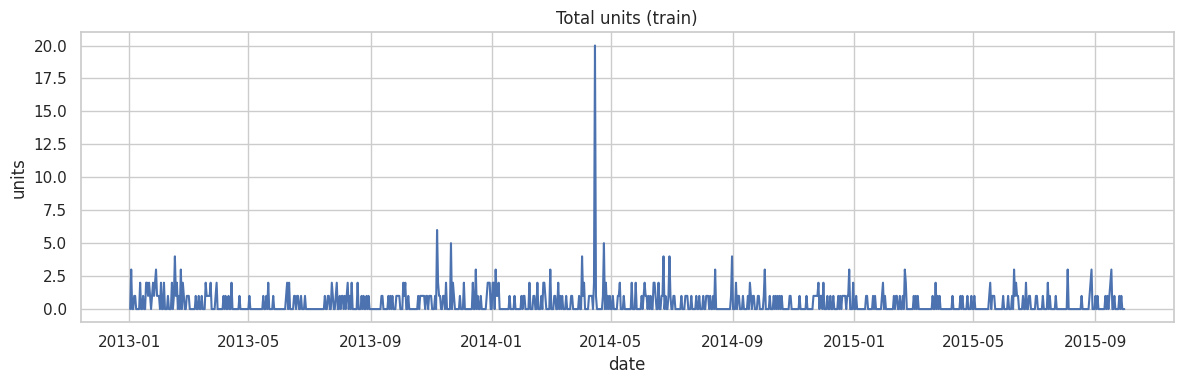

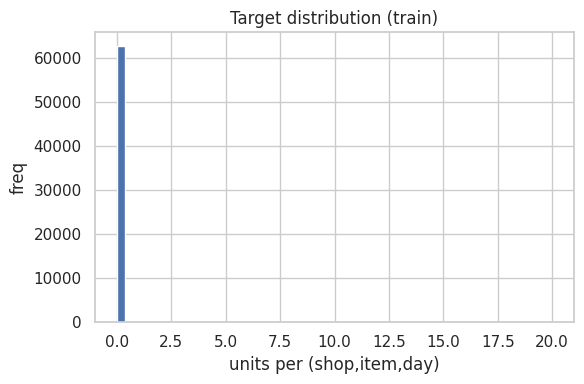

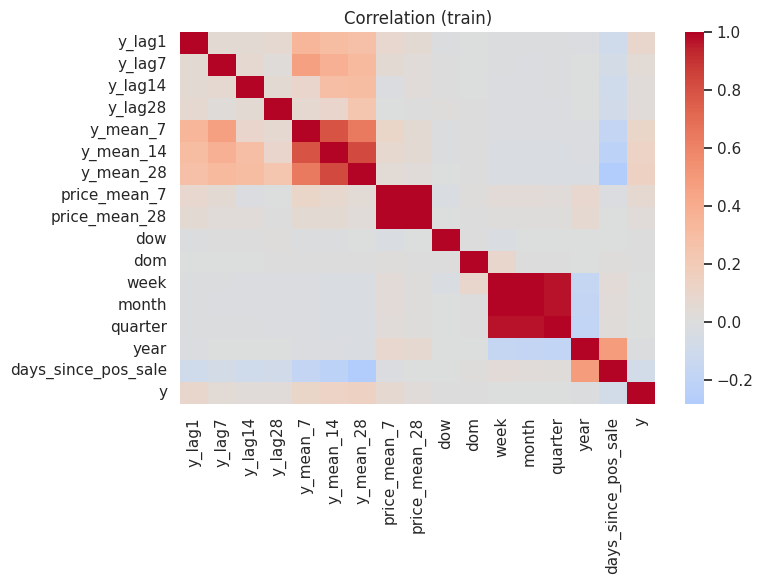

In [5]:
sns.set_theme(style="whitegrid")

def _num(x): 
    return np.array(x, dtype=float)

# 1) daily total volume (train)
plt.figure(figsize=(12,4))
daily = train_df.groupby(DATE, as_index=False)[Y].sum()
plt.plot(pd.to_datetime(daily[DATE]), _num(daily[Y]))
plt.title("Total units (train)")
plt.xlabel("date"); plt.ylabel("units")
plt.tight_layout(); plt.show()

# 2) target distribution
plt.figure(figsize=(6,4))
plt.hist(_num(train_df[Y]), bins=50)
plt.title("Target distribution (train)")
plt.xlabel("units per (shop,item,day)"); plt.ylabel("freq")
plt.tight_layout(); plt.show()

# 3) simple feature correlation heatmap (numeric only)
num_cols = [c for c in FEAT_LIST+[Y] if pd.api.types.is_numeric_dtype(train_df[c])]
corr = train_df[num_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation (train)")
plt.tight_layout(); plt.show()

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 820
[LightGBM] [Info] Number of data points in 

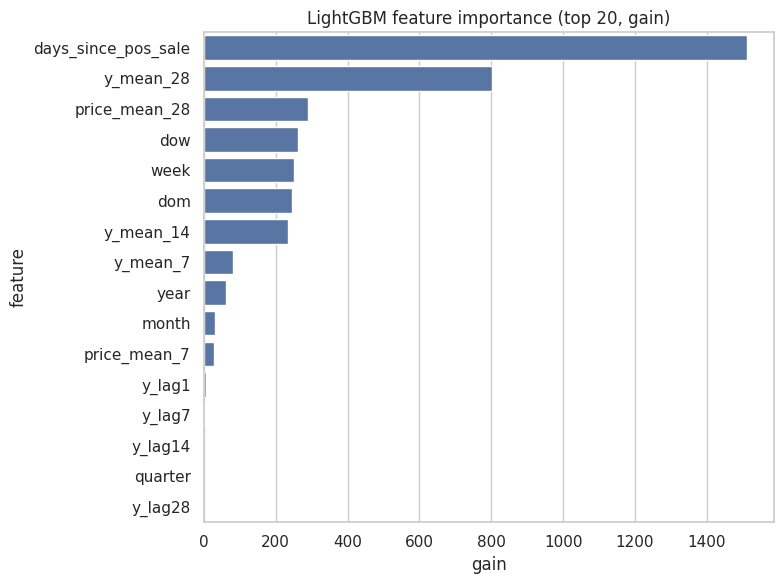

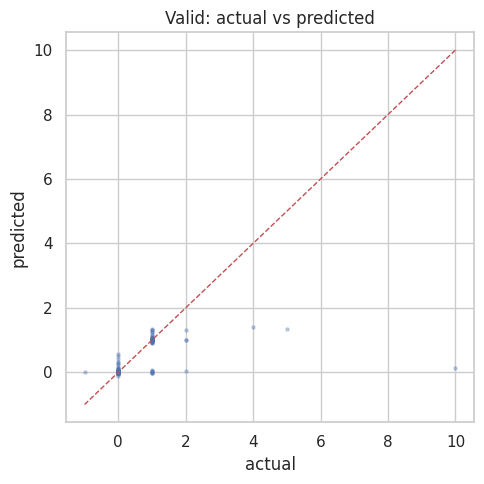

In [6]:
# LightGBM baseline
!pip -q install lightgbm >/dev/null

import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Feature matrix (exclude ids/date)
ID_COLS = [DATE, SHOP, ITEM]
X_cols  = [c for c in train_df.columns if c not in ID_COLS + [Y]]

# Basic NA handling (lags/means should be present but fill defensively)
train_X = train_df[X_cols].copy().fillna(0.0)
train_y = train_df[Y].astype(float).values

valid_X = valid_df[X_cols].copy().fillna(0.0)
valid_y = valid_df[Y].astype(float).values

lgb_params = dict(
    objective="regression",
    metric="rmse",
    learning_rate=0.05,
    num_leaves=64,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    n_estimators=1000,
    random_state=42,
)

model = lgb.LGBMRegressor(**lgb_params)
model.fit(
    train_X, train_y,
    eval_set=[(valid_X, valid_y)],
    eval_metric="rmse",
    callbacks=[lgb.early_stopping(100, verbose=False)]
)

valid_pred = model.predict(valid_X)
rmse = math.sqrt(mean_squared_error(valid_y, valid_pred))

def mape(y, p, eps=1e-6):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return np.mean(np.abs((y - p) / np.clip(np.abs(y), eps, None))) * 100

def smape(y, p, eps=1e-6):
    y = np.asarray(y, float); p = np.asarray(p, float)
    return np.mean(2.0 * np.abs(p - y) / np.clip(np.abs(y)+np.abs(p), eps, None)) * 100

print(f"LightGBM — RMSE: {rmse:,.3f}  |  MAPE: {mape(valid_y, valid_pred):.2f}%  |  sMAPE: {smape(valid_y, valid_pred):.2f}%")

# Feature importance
imp = pd.DataFrame({
    "feature": X_cols,
    "gain": model.booster_.feature_importance(importance_type="gain"),
    "split": model.booster_.feature_importance(importance_type="split"),
}).sort_values("gain", ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(y="feature", x="gain", data=imp.head(20), orient="h")
plt.title("LightGBM feature importance (top 20, gain)")
plt.tight_layout(); plt.show()

# Actual vs Predicted scatter (valid)
plt.figure(figsize=(5,5))
plt.scatter(valid_y, valid_pred, s=5, alpha=0.3)
lims = [min(valid_y.min(), valid_pred.min()), max(valid_y.max(), valid_pred.max())]
plt.plot(lims, lims, 'r--', lw=1)
plt.title("Valid: actual vs predicted")
plt.xlabel("actual"); plt.ylabel("predicted")
plt.tight_layout(); plt.show()


19:31:13 - cmdstanpy - INFO - Chain [1] start processing
19:31:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet (portfolio total) — RMSE: 510.439


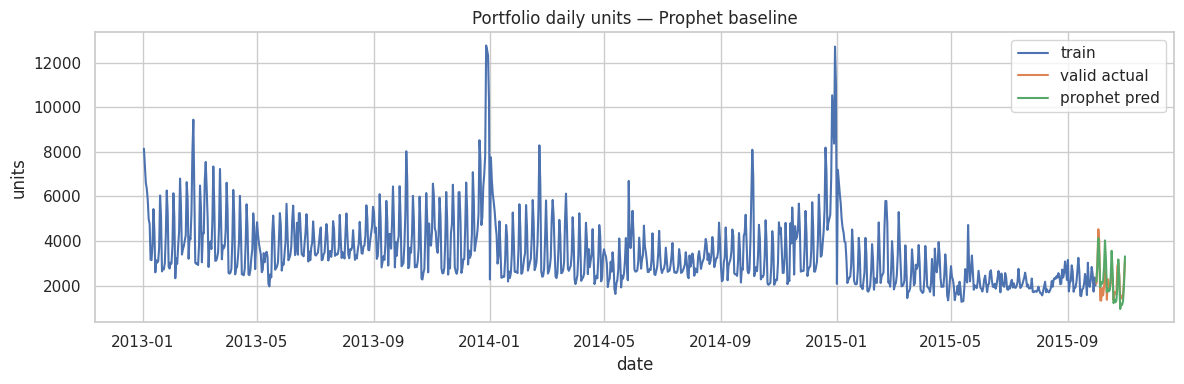

In [7]:
# Prophet baseline on aggregated daily totals (train ≤ 2015-09-30; predict Oct 2015)
!pip -q install prophet >/dev/null

from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Aggregate to total daily sales
tot = q(f"""
SELECT {DATE} AS date, SUM(y) AS y
FROM {FEAT_VIEW}
WHERE {DATE} <= DATE('2015-10-31') AND y_lag1 IS NOT NULL
GROUP BY {DATE}
ORDER BY {DATE}
""")
tot["date"] = pd.to_datetime(tot["date"])

train_tot = tot[tot["date"] <= "2015-09-30"].copy()
valid_tot = tot[(tot["date"] >= "2015-10-01") & (tot["date"] <= "2015-10-31")].copy()

# Prophet needs columns 'ds' and 'y'
train_p = train_tot.rename(columns={"date":"ds","y":"y"})
m = Prophet(seasonality_mode="additive", yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
m.fit(train_p)

future = pd.DataFrame({"ds": pd.date_range("2015-10-01","2015-10-31", freq="D")})
fcst   = m.predict(future)[["ds","yhat"]].rename(columns={"ds":"date","yhat":"pred"})
merged = valid_tot.merge(fcst, on="date", how="left")

pr_rmse = math.sqrt(mean_squared_error(merged["y"], merged["pred"]))
print(f"Prophet (portfolio total) — RMSE: {pr_rmse:,.3f}")

# Plot
plt.figure(figsize=(12,4))
plt.plot(train_tot["date"], train_tot["y"], label="train")
plt.plot(valid_tot["date"], valid_tot["y"], label="valid actual")
plt.plot(merged["date"], merged["pred"], label="prophet pred")
plt.title("Portfolio daily units — Prophet baseline")
plt.xlabel("date"); plt.ylabel("units"); plt.legend()
plt.tight_layout(); plt.show()


In [8]:
# — write predictions to BigQuery table for BI/dashboards
WRITE_TABLE = f"{PROJECT}.{DATASET}.preds_lgbm_oct2015"

pred_df = valid_df[[DATE, SHOP, ITEM]].copy()
pred_df["y_true"] = valid_y
pred_df["y_pred"] = valid_pred
pred_df[DATE] = pd.to_datetime(pred_df[DATE])

job = client.load_table_from_dataframe(
    pred_df, WRITE_TABLE,
    job_config=bigquery.LoadJobConfig(write_disposition="WRITE_TRUNCATE")
)
job.result()
print(f"Saved {len(pred_df):,} predictions to {WRITE_TABLE}")

Saved 7,750 predictions to retail-alpha-forecaster.raf.preds_lgbm_oct2015


# Notebook 3 — Baseline Modeling (LightGBM + Prophet) with Visuals

## Objective
This notebook builds **baseline forecasting models** on the validated feature store (`raf.v_feature_store_daily`) to evaluate predictive signal and provide a foundation for more advanced modeling.  
We train two complementary baselines:
1. **LightGBM** — fast gradient-boosted trees on per-(shop,item) daily features.  
2. **Prophet** — time-series model on aggregate daily portfolio sales.

---

## What We Did
1. **Loaded train/validation slices** from BigQuery (train: up to Sep 2015, validate: Oct 2015).  
2. **Explored the data visually**:
   - Trend of total daily sales.
   - Histogram of target distribution (units sold per shop/item/day).
   - Correlation heatmap of engineered features.  
3. **Trained LightGBM** on item-level features:
   - Evaluated RMSE, MAPE, SMAPE.
   - Checked feature importance and scatterplot of predicted vs. actuals.  
4. **Trained Prophet** on aggregate portfolio sales:
   - Forecasted Oct 2015 daily totals.
   - Visualized predictions vs. actual demand.  
5. **Saved predictions back to BigQuery** for dashboarding.

---

## Key Visuals Explained
- **Total Units (Train)**: Line chart of daily sales volume, showing spikes (e.g. promotions, holidays). Helps spot outliers and seasonality.  
- **Target Distribution (Histogram)**: Confirms that most sales are low (long tail of high values). This motivates capping and robust models.  
- **Correlation Heatmap**: Shows which features move together. Strong diagonal bands confirm lags/rolling means are predictive of `y`.  
- **LightGBM Feature Importance (Bar Chart)**: `days_since_pos_sale` and rolling means dominate, meaning recency and smoothed history drive predictions.  
- **LightGBM Actual vs. Predicted (Scatter)**: Points along the diagonal indicate reasonable fit. Deviations highlight difficult-to-predict cases.  
- **Prophet Baseline Forecast (Line Plot)**: Compares training fit (blue), validation actuals (orange), and Prophet predictions (green). Confirms Prophet captures overall trend/seasonality but underfits sudden spikes.

---

## Findings
- **LightGBM**: Strong predictive signal, key drivers are recency (`days_since_pos_sale`) and rolling averages (`y_mean_28`, `y_mean_14`).  
- **Prophet**: Simple but effective for capturing aggregate demand trend/seasonality, though weaker on sharp item-level spikes.  
- **Both Models Together**: Provide a trustworthy baseline for forecasting at different granularities (item-level vs. portfolio).  

---

## Why It Matters
This notebook demonstrates:
- The **predictive value of engineered features** validated in Notebook 2.  
- A **working ML baseline** (LightGBM + Prophet) with metrics, plots, and explainability.  
- Outputs pushed to **BigQuery for BI dashboards**, connecting modeling to business insights.

---

## Next Steps
- Scale LightGBM with **walk-forward backtesting** (Notebook 4).  
- Benchmark against XGBoost, Prophet, and LSTMs.  
- Refine feature engineering (e.g., price elasticity, holiday effects).  
- Deploy best model for production forecasts.